# Abandoned code with lanes displayed


In [1]:
import cv2
import glob
import os
import sys
import numpy as np

from random import randint
import matplotlib.pyplot as plt

import tensorflow as tf

import socket
import json

from time import time
from cav.objects import Object, BoundingBox, ObjectType
from cav.parameters import Parameters

from cav.visualization import Map, plotBoxes, bsmImg

from copy import deepcopy

# Deep sort imports
from deep_sort import nn_matching
from deep_sort.tracker import Tracker
from deep_sort.detection import Detection
%matplotlib inline 

/home/przemek/anaconda3/envs/cav/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


### BSM Server configuration

In [2]:
PUSH_BSM = False # If true, bsms are being pushed to the server

HOST = '128.8.215.214'   # The server's hostname or IP address
PORT = 65432        # The port used by the server
DATA_BUFF = 4096

In [3]:
# FUnction that sends data
def sendBsm(s, bsm):
    data = {
        'mode' : 'push',
        'msg' : bsm
    }
    
    msg = json.dumps(data)
    msg = str.encode(msg)
    s.sendall(msg)
    data = s.recv(1024)  
    return data    

## Doublecheck

In [4]:
class ImageEncoder(object):

    def __init__(self, checkpoint_filename, input_name="images",
                 output_name="features"):
        
        self.tf_version = int(tf.__version__.split('.')[0])
        
        if self.tf_version == 1:
            self.session = tf.Session()
            with tf.io.gfile.GFile(checkpoint_filename, "rb") as file_handle:
                graph_def = tf.GraphDef()
                graph_def.ParseFromString(file_handle.read())
            
        else:
            self.session = tf.compat.v1.Session()
            
            with tf.io.gfile.GFile(checkpoint_filename, "rb") as file_handle:
                graph_def = tf.compat.v1.GraphDef() 
                graph_def.ParseFromString(file_handle.read())
            
        tf.import_graph_def(graph_def, name="net")
        
        if self.tf_version == 1:
            self.input_var = tf.get_default_graph().get_tensor_by_name(
                "net/%s:0" % input_name)
            self.output_var = tf.get_default_graph().get_tensor_by_name(
                "net/%s:0" % output_name)
        else: # TF 2
            self.input_var = tf.compat.v1.get_default_graph().get_tensor_by_name(
                "%s:0" % input_name)
            self.output_var = tf.compat.v1.get_default_graph().get_tensor_by_name(
            "%s:0" % output_name)
                    
        assert len(self.output_var.get_shape()) == 2
        assert len(self.input_var.get_shape()) == 4
        self.feature_dim = self.output_var.get_shape().as_list()[-1]
        self.image_shape = self.input_var.get_shape().as_list()[1:]

    def __call__(self, data_x, batch_size=32):
        out = np.zeros((len(data_x), self.feature_dim), np.float32)
        _run_in_batches(
            lambda x: self.session.run(self.output_var, feed_dict=x),
            {self.input_var: data_x}, out, batch_size)
        return out

    
def create_box_encoder(model_filename, input_name="images",
                       output_name="features", batch_size=32):
    image_encoder = ImageEncoder(model_filename, input_name, output_name)
    image_shape = image_encoder.image_shape

    def encoder(image, boxes):
        image_patches = []
        for box in boxes:
            patch = extract_image_patch(image, box, image_shape[:2])
            if patch is None:
                print("WARNING: Failed to extract image patch: %s." % str(box))
                patch = np.random.uniform(
                    0., 255., image_shape).astype(np.uint8)
            image_patches.append(patch)
        image_patches = np.asarray(image_patches)
        return image_encoder(image_patches, batch_size)

    return encoder

In [5]:
def _run_in_batches(f, data_dict, out, batch_size):
    data_len = len(out)
    num_batches = int(data_len / batch_size)

    s, e = 0, 0
    for i in range(num_batches):
        s, e = i * batch_size, (i + 1) * batch_size
        batch_data_dict = {k: v[s:e] for k, v in data_dict.items()}
        out[s:e] = f(batch_data_dict)
    if e < len(out):
        batch_data_dict = {k: v[e:] for k, v in data_dict.items()}
        out[e:] = f(batch_data_dict)
        
        
def extract_image_patch(image, bbox, patch_shape):
    """Extract image patch from bounding box.

    Parameters
    ----------
    image : ndarray
        The full image.
    bbox : array_like
        The bounding box in format (x, y, width, height).
    patch_shape : Optional[array_like]
        This parameter can be used to enforce a desired patch shape
        (height, width). First, the `bbox` is adapted to the aspect ratio
        of the patch shape, then it is clipped at the image boundaries.
        If None, the shape is computed from :arg:`bbox`.

    Returns
    -------
    ndarray | NoneType
        An image patch showing the :arg:`bbox`, optionally reshaped to
        :arg:`patch_shape`.
        Returns None if the bounding box is empty or fully outside of the image
        boundaries.

    """
    bbox = np.array(bbox)
    if patch_shape is not None:
        # correct aspect ratio to patch shape
        target_aspect = float(patch_shape[1]) / patch_shape[0]
        new_width = target_aspect * bbox[3]
        bbox[0] -= (new_width - bbox[2]) / 2
        bbox[2] = new_width

    # convert to top left, bottom right
    bbox[2:] += bbox[:2]
    bbox = bbox.astype(np.int)

    # clip at image boundaries
    bbox[:2] = np.maximum(0, bbox[:2])
    bbox[2:] = np.minimum(np.asarray(image.shape[:2][::-1]) - 1, bbox[2:])
    if np.any(bbox[:2] >= bbox[2:]):
        return None
    sx, sy, ex, ey = bbox
    image = image[sy:ey, sx:ex]
    image = cv2.resize(image, tuple(patch_shape[::-1]))
    return image


In [6]:
ENCODER_PATH = "./deep_sort_network/mars-small128.pb"
ENCODER_BATCH_SIZE = 1
#ENCODER_INPUT_NAME = "images"
#ENCODER_OUTPUT_NAME = "features"

#image_encoder = ImageEncoder(ENCODER_PATH, ENCODER_INPUT_NAME, ENCODER_OUTPUT_NAME)
encoder = create_box_encoder(ENCODER_PATH, batch_size=32)

## Create tracker

In [7]:
max_cosine_distance = 0.2
nn_budget = 100

metric = nn_matching.NearestNeighborDistanceMetric(
    "cosine", max_cosine_distance, nn_budget)

### Create object detector

In [8]:
from cav.detection import ObjectDetector
import cv2
MODEL_PATH = '../../CAV/models/frcnn/inference/saved_model/'
od = ObjectDetector(MODEL_PATH)

### Create params and map objects

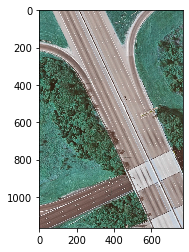

In [9]:
params = Parameters()
params.generateParameters('./config/params_US695_MD295.json')
mymap = Map('./images/US-695_MD-294.jpg', './config/icons.json', params)
plt.imshow(mymap.getMap(), interpolation='nearest')
plt.show()

#### Logging parameters

In [10]:
PREPARE_VISUALIZATION = True ### Temporary and ugly - Should be cleaned soon
LANES_IMG_PATH = None
LANES_IMG_PATH = './images/lanes_4.jpg'
SAVE_FRAMES = False # Doesn't work yet, an idea how to correct PREPARE_VISUALIZATION
SAVE_VIDEO = False # Doesn't work yet, an idea how to correct PREPARE_VISUALIZATION

SAVE_LOG = None #### Saves logs with all detected objects (path to file or none)
#SAVE_LOG = 'test_log_20201028.csv'
SAVE_EMPTY_FRAMES = None ### Folder where empty frames shall be saved
#SAVE_EMPTY_FRAMES = './empty_frames'


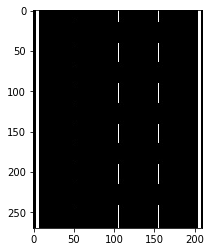

In [11]:
if LANES_IMG_PATH is not None:
    lanesparams = Parameters()
    lanesparams.generateParameters('./config/params_US695_MD295_Lanes.json')    
    lanemap = Map(LANES_IMG_PATH, './config/icons_lanes.json', lanesparams)    
    plt.imshow(lanemap.getMap(), interpolation='nearest')
    plt.show()    

#### Other parameters

In [12]:
VIDEO_CUT_UPPER = 170 # Delete first Y rows
VIDEO_CUT_LEFT = 300 # Delete firx X columns
LANE_SHIFT_LEFT = 60 # Shift  lane map to the left

VIDEO_X = 640 - VIDEO_CUT_LEFT # Replace with params values (modify params class)
VIDEO_Y = 480 - VIDEO_CUT_UPPER # Replace with params values


FRAMES_SEC = 15

MAX_BOXES_TO_DRAW = 50
MIN_SCORE_THRESH = 0.5
IOU_COMMON_THRESHOLD = 0.50
NOT_DETECTED_TRHESHOLD = 1

MAPSHAPE = mymap.getMap().shape
print ('Y dimension of map is {:.3f} larger than Y dimension of the video'
      .format(MAPSHAPE[0] / VIDEO_Y))

MAP_RESIZE = 2

print ('Y dimension of map is {:.3f} larger than Y dimension of the video. Size of the map is reduced {} times.'
      .format(MAPSHAPE[0] / VIDEO_Y, MAP_RESIZE))

BSM_X = 0

FINAL_X = VIDEO_X + int(MAPSHAPE[1] / MAP_RESIZE) + BSM_X
FINAL_Y = max(VIDEO_Y, int(MAPSHAPE[0] / MAP_RESIZE))

print ('Video size: [{}, {}], Final size: [{}, {}]'
      .format(VIDEO_X, VIDEO_Y, FINAL_X, FINAL_Y))

RESIZE = False

Y dimension of map is 3.765 larger than Y dimension of the video
Y dimension of map is 3.765 larger than Y dimension of the video. Size of the map is reduced 2 times.
Video size: [340, 310], Final size: [724, 583]


In [13]:
print (MAPSHAPE[0] / VIDEO_Y)

3.764516129032258


In [14]:
cap = cv2.VideoCapture('/data/MoveOver/Videos/Amir_20210126/2021-01-25 11.44.23/I-695 AT BALTIMORE WASHINGTON PKWY.mp4')
#cap.open("rtsp://128.8.215.215/1")

fourcc = cv2.VideoWriter_fourcc(*'XVID')

prepare_visualization_base = PREPARE_VISUALIZATION

if PREPARE_VISUALIZATION:
    if RESIZE:
        out = cv2.VideoWriter('Test1_output.avi',fourcc, 2*FRAMES_SEC, (int(FINAL_X/2), int(FINAL_Y/2)))
    else:
        out = cv2.VideoWriter('Test1_output.avi',fourcc, 2*FRAMES_SEC, (int(FINAL_X), int(FINAL_Y)))
else:
    out = None


objects = []

results = []
colors = {}


tracker = Tracker(metric)

i = 0
t = time()

with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    if PUSH_BSM:
        s.connect((HOST, PORT))
    while cap.isOpened():
                
        fps = cap.get(cv2.CAP_PROP_FPS)
    
        t2 = time() - t
        sys.stdout.write('{} frames done in {:.1f} seconds ({:.2f} frames/sec)    \r'.format(
            i, t2, i/t2))                   
        #sys.stdout.write("Processing Frame {}     \r".format(i))
        ret, image = cap.read()

        if VIDEO_CUT_UPPER > 0:
            image = image[VIDEO_CUT_UPPER:, :, :]        

        if VIDEO_CUT_LEFT > 0:
            image = image[:, VIDEO_CUT_LEFT:, :]        
            
            
        boxes, scores, classes = od.detect(image)
        if len(boxes) >= 1:

            boxes_array = [[box.xLeft, box.yTop, box.xRight - box.xLeft, box.yBottom - box.yTop] for box in boxes]
            boxes_array = np.array(boxes_array)
            bgr_image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            features = encoder(bgr_image, boxes_array)
            detections = []

            for box, score, objClass, f_vector in zip(boxes, scores, classes, features):
                detection = Detection(
                    [box.xLeft, box.yTop, box.xRight - box.xLeft, box.yBottom - box.yTop], #BBox
                    score, f_vector,
                    objClass
                )
                detection.bbox = box
                detections.append(detection)

            tracker.predict()
            tracker.update(detections)                
            
            # Added to save only important frames DELETE LATER
            PREPARE_VISUALIZATION = True
        else:
            tracker.predict()
            PREPARE_VISUALIZATION = prepare_visualization_base
            
        plotboxes = []
        plotcolors = []
        objects = []

        if len(tracker.tracks) >= 1:
            for track in tracker.tracks:
                if not track.is_confirmed() or track.time_since_update > 1:
                    continue

                if False:
                    bbox = track.to_tlwh()
                    results.append([
                        i, track.track_id, bbox[0], bbox[1], bbox[2], bbox[3]])


                obj = track.trackedObject

                if obj is not None:
                    if obj.color is None:
                        obj.color = (randint(0, 255), randint(0, 255), randint(0, 255))                        
                    
                    plotbox = obj.bboxes[-1]
                    plotbox.trackId = track.track_id
                    plotboxes.append(plotbox)
                    plotcolors.append(obj.color)
                    objects.append(obj)
                    

            if len(plotboxes) >= 1:
                vid = plotBoxes(image, plotboxes, colors=plotcolors)
            else:
                vid = image.copy()
                mapimg = mymap.getMap()

            if PREPARE_VISUALIZATION:
                mapimg = mymap.addObjects(objects)   
                if LANES_IMG_PATH is not None:
                    laneobjects = []
                    for obj in objects:
                        laneobj = deepcopy(obj)
                        laneobj.updateBBoxParams(lanesparams, force_update = True)
                        laneobjects.append(laneobj)
                    laneimg = lanemap.addObjects(laneobjects, use_obj_color = True)
        elif PREPARE_VISUALIZATION:
                vid = image.copy()
                mapimg = mymap.getMap()
                if LANES_IMG_PATH is not None:
                    laneimg = lanemap.getMap()

        # Adding map
        if PREPARE_VISUALIZATION:
            if MAP_RESIZE != 1: # Reducing the size of the map
                width = int(mapimg.shape[1] / MAP_RESIZE)
                height = int(mapimg.shape[0] / MAP_RESIZE)
                dim = (width, height)
                # resize image
                mapimg = cv2.resize(mapimg, dim, interpolation = cv2.INTER_AREA)                   
                    
            final_image = np.zeros((FINAL_Y, FINAL_X,3),dtype=np.uint8)

            final_image[:VIDEO_Y, :VIDEO_X, :] = vid
            final_image[:mapimg.shape[0], VIDEO_X:VIDEO_X + mapimg.shape[1], :] = mapimg     

            
            if LANES_IMG_PATH is not None:
                final_image[VIDEO_Y:VIDEO_Y + laneimg.shape[0], 
                            LANE_SHIFT_LEFT: LANE_SHIFT_LEFT + laneimg.shape[1], :] = laneimg
            
            
            
        if (BSM_X > 0) & PREPARE_VISUALIZATION:
            if len(objects) > 0:
                obj = objects[0]
                color = obj.color
                bsmimg = bsmImg(obj.getBsm(params=params), framecolor=color)
                final_image[:bsmimg.shape[0], VIDEO_X + mapimg.shape[1]:, :] =  bsmimg

            if len(objects) > 1:
                obj = objects[1]
                color = obj.color
                bsmimg = bsmImg(obj.getBsm(params=params), framecolor=color)
                #final_image[bsmimg.shape[0]+10:2*bsmimg.shape[0]+10, VIDEO_X + mapimg.shape[1]:, :] =  bsmimg

                

                
                
        if PREPARE_VISUALIZATION & RESIZE: # Resize image
            width = int(final_image.shape[1] / 2)
            height = int(final_image.shape[0] / 2)
            dim = (width, height)
            # resize image
            final_image = cv2.resize(final_image, dim, interpolation = cv2.INTER_AREA)

        if PREPARE_VISUALIZATION:
            cv2.imwrite('./tmp/im_{}.jpg'.format(str(i).zfill(4)), final_image)
            if out is not None:
                out.write(final_image)            
                
            
            
        bsm_list = []
        
        if len(objects) > 0:
            for obj in objects:
                bsm_list.append(obj.getBsm(retDic = False, params=params, roundValues = True, includeNone = False))

            #print (bsm_list)
            if PUSH_BSM:
                data = sendBsm(s, json.dumps(bsm_list))
                #print ("Response: {}\n".format(data))            

                
            if SAVE_EMPTY_FRAMES is not None:
                cv2.imwrite('{}/im_{}.jpg'.format(SAVE_EMPTY_FRAMES, str(i).zfill(4)), image)
                
            if SAVE_LOG is not None:
                logfile = open('./logs/{}'.format(SAVE_LOG, 'w'))
                for obj in objects:
                    line = '{},{},{}'.format(i,time(),obj.getParams(asCsv=true))                               
                    print(line,file=logfile)                    
                                
        i = i+1
        if False: #i > 5* FRAMES_SEC:
            if False:
                f = open('tmp_tracking_results_demo.txt', 'w')
                for row in results:
                    print('%d,%d,%.2f,%.2f,%.2f,%.2f,1,-1,-1,-1' % (
                        row[0], row[1], row[2], row[3], row[4], row[5]),file=f)        
            break
                  
            
                        
t = time() - t                             
print('\n\n{} frames done in {:.1f} seconds ({:.2f} frames/sec)'.format(
    i, t, i/t))                             
cap.release()
    


KeyboardInterrupt: 

# Generate Video

In [ ]:
print ('({}x{}), {:.1f} fps'.format(FINAL_X, FINAL_Y, fps))

In [15]:
import glob

out = None

filenames = glob.glob('./tmp/*.jpg')
filenames.sort()
for i, filename in enumerate(filenames):
    if i%10 == 0:
        sys.stdout.write('{:.1f}% ({}/{}) done.             \r'.format(
            100*i/len(filenames), i, len(filenames)))
    img = cv2.imread(filename)
    if out is None:
        height, width, layers = img.shape
        size = (width,height)
        out = cv2.VideoWriter('Test1_output.avi',cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    out.write(img) 
 
out.release()
print ('100% done!                            ')

100% done!                            
